# Goncimik'in Perspektifinden: CNN Mimarisi

Merhaba 👋  
Bu benim burada paylaştığım **ilk projem**.  

Bu çalışmam, **Akbank Derin Öğrenme Bootcamp: Yeni Nesil Proje Kampı** kapsamında hazırlandı.  
Amaç, **CNN mimarisi** ve **Transfer Learning** yöntemlerini kullanarak görüntü sınıflandırma problemini çözmektir.  

# Intel Image Classification İle CNN Projesi

Bu projede, **Convolutional Neural Networks (CNN)** kullanılarak sınıflandırma modeli geliştirildi.  
Kullanılan veri seti:
[Intel Image Classification](https://www.kaggle.com/datasets/puneet6060/intel-image-classification)  

### Veri Seti Hakkında
- **Tür:** Multiclass Image Classification  
- **Sınıflar:** Buildings, Forest, Glacier, Mountain, Sea, Street  
- **Boyut:** ~25.000 eğitim, 14.000 test görüntüsü  


#  Minik Ama Güçlü Bir Ayar: Seed  
Modelin her çalıştırmada aynı sonuçları üretmesi için global seed ayarlandı.  

In [43]:
import os, random, numpy as np
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
random.seed(SEED)
np.random.seed(SEED)

# Gerekli Kütüphanelerin Yüklenmesi
Aşağıdaki kütüphaneler projede kullanıldı:
- **numpy, pandas**: Veri işleme  
- **matplotlib, seaborn**: Görselleştirme  
- **tensorflow/keras**: CNN tabanlı derin öğrenme modeli kurmak
- **sklearn**: Model değerlendirmesinde `classification_report` ve `confusion_matrix`  
- **warnings**: Gereksiz uyarıları kapatmak.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')
tf.random.set_seed(42)

# GPU Kontrolü
TensorFlow ile GPU kullanılabilirliği kontrol edildi.

In [44]:
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


#  Veri Keşfi & Görselleştirme (EDA)
Intel Image Classification veri setinde toplam 6 sınıf vardır.
    
**Sınıf İsimleri**:
   - Buildings
   - Forest
   - Glacier
   - Mountain
   - Sea
   - Street
    
 **Sınıf Dağılımı**:
    Eğitim (train) klasöründeki her sınıfta kaç görüntü olduğu öğrenildi.

 **Örnek Görseller**: 
    Her sınıftan bir örnek görsel ile veri setinin yapısı hakkında bilgi verildi.

Sınıflar:
- mountain
- street
- buildings
- sea
- forest
- glacier

Sınıf dağılımı:
- mountain: 2512
- street: 2382
- buildings: 2191
- sea: 2274
- forest: 2271
- glacier: 2404


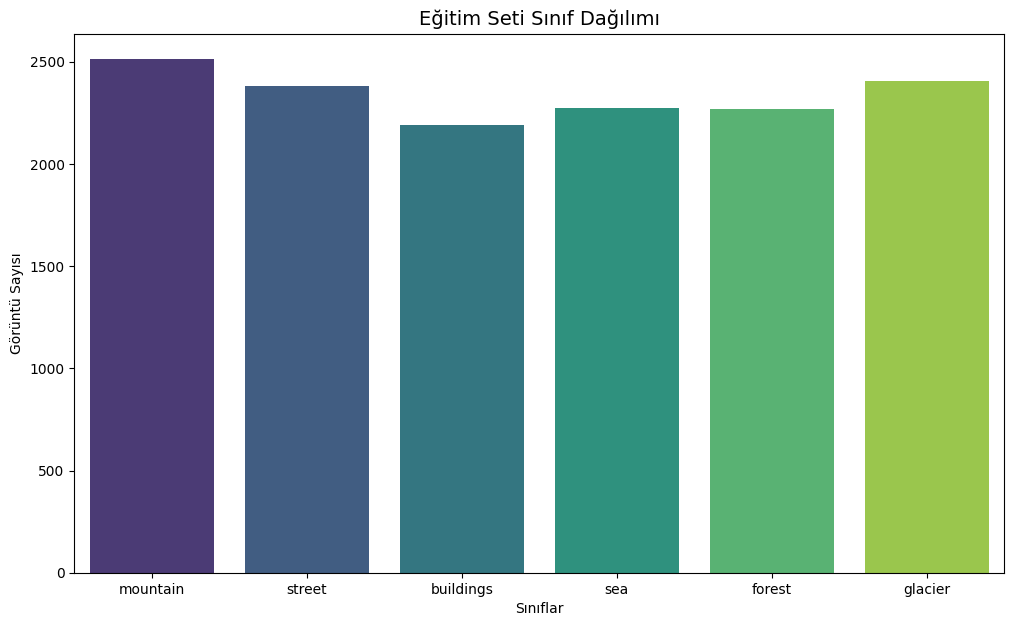

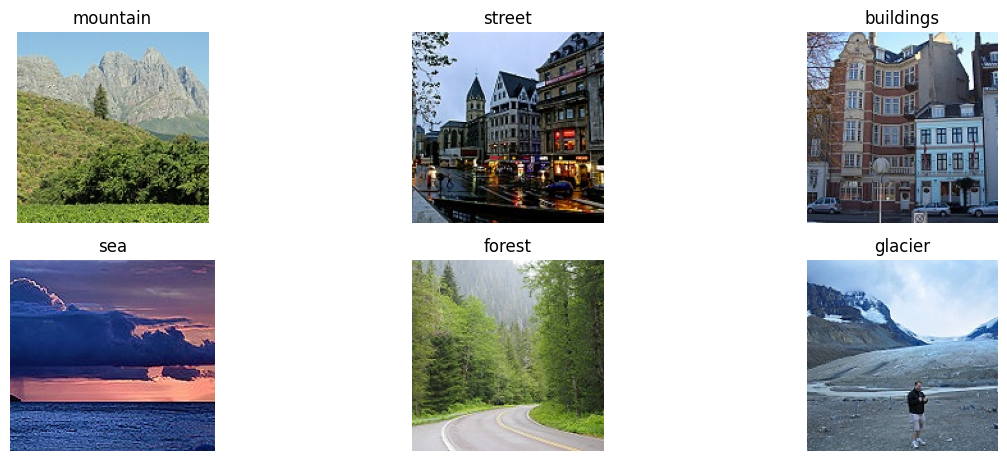

In [45]:
import os
import random
import numpy as np
import matplotlib.image as mpimg
import numpy as np

random.seed(SEED) 
np.random.seed(SEED)

base_dir = "../input/intel-image-classification/"
train_dir = os.path.join(base_dir, "seg_train/seg_train")


class_names = os.listdir(train_dir)
print("Sınıflar:")
for cls in class_names:
    print(f"- {cls}")


class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in class_names}

print("\nSınıf dağılımı:")
for cls, count in class_counts.items():
    print(f"- {cls}: {count}")


plt.figure(figsize=(12,7))
sns.barplot(
    x=list(class_counts.keys()), 
    y=list(class_counts.values()), 
    palette="viridis")
plt.title("Eğitim Seti Sınıf Dağılımı", fontsize=14)
plt.ylabel("Görüntü Sayısı")
plt.xlabel("Sınıflar")
plt.show()


plt.figure(figsize=(12, 7))
for i, cls in enumerate(class_names):
   
    img_path = os.path.join(train_dir, cls, random.choice(os.listdir(os.path.join(train_dir, cls))))
    img = mpimg.imread(img_path)
    
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.tight_layout()
plt.show()

#  Veri Önişleme & Data Augmentation
Veri seti **80% train / 10% validation / 10% test** olarak ayrıldı.
    
Görsellerin boyutu **150 × 150** olarak sabitlendi.  

Modelin daha iyi genelleme yapabilmesi için **Data Augmentation** uygulandı.  

Eğitim görselleri üzerinde rastgele dönüşümler yapıldı.  

Kullanılan dönüşümler:  
- **RandomFlip** → Görselleri yatay çevirme  
- **RandomRotation** → ±%10 döndürme  
- **RandomZoom** → Yakınlaştırma / uzaklaştırma  
- **RandomContrast** → Kontrast değişimi  

In [47]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


IMG_SIZE = (150, 150)
BATCH = 32
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE


TRAIN_DIR = os.path.join(base_dir, "seg_train/seg_train")
TEST_DIR = os.path.join(base_dir, "seg_test/seg_test")


train_ds = keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    validation_split=0.1,   
    subset="training",
    seed=SEED,
    label_mode="int")

val_ds = keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    validation_split=0.1,
    subset="validation",
    seed=SEED,
    label_mode="int")

test_ds = keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False,
    label_mode="int")

class_names = train_ds.class_names
print("Sınıflar:", class_names)

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")

Found 14034 files belonging to 6 classes.
Using 12631 files for training.
Found 14034 files belonging to 6 classes.
Using 1403 files for validation.
Found 3000 files belonging to 6 classes.
Sınıflar: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


#  Model: CNN Mimarisi 
CNN Model mimarisi şu bileşenleri içermektedir:  

- **Conv2D Katmanları**: Görüntüden öznitelik çıkarmak  
- **MaxPooling2D**: Özellik haritalarını küçültmek, parametre sayısını azaltmak
- **Dropout**: Overfitting’i önlemek  
- **Dense Katmanları**: Tam bağlı katmanlarla sınıflandırma yapmak 
- **ReLU & Softmax**: Aktivasyon fonksiyonları  

Ayrıca modelin ilk katmanında  **normalizasyon (Rescaling)** ve **data augmentation** uygulandı.

In [48]:
from tensorflow.keras import layers, models

def build_model(img_size=IMG_SIZE, num_classes=len(class_names)):
    inputs = keras.Input(shape=img_size + (3,))
    
   
    x = layers.Rescaling(1./255)(inputs)
    x = data_augmentation(x)
    
    # Blok 1
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.2)(x)
    
    # Blok 2
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.3)(x)
    
    # Blok 3
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.4)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = keras.Model(inputs, outputs, name="intel_cnn")
    return model

model = build_model()
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",  
    metrics=["accuracy"])
model.summary()

Model: "intel_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 37, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,596,838 (21.35 MB)

 Trainable params: 5,596,582 (21.35 MB)

 Non-trainable params: 256 (1.00 KB)

# CNN Modelinin Eğitilmesi

- Eğitim verisi (**train_ds**) ile model öğrendi.  
- Doğrulama verisi (**val_ds**) ile overfitting kontrol edildi.  
- Eğitim sürecini hızlandırmak ve en iyi sonucu almak için **EarlyStopping** kullanıldı.  
- Eğitim sonrası **accuracy** ve **loss** grafikleri ile  görselleştirildi.

# Modelin 20 Epoch ile Eğitimi
Model ilk olarak 20 epoch ile eğitildi.

Epoch 1/20


E0000 00:00:1758879170.445669      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/intel_cnn_1/dropout_8_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


395/395 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - accuracy: 0.4898 - loss: 1.2940 - val_accuracy: 0.6187 - val_loss: 0.9614
Epoch 2/20
395/395 ━━━━━━━━━━━━━━━━━━━━ 40s 101ms/step - accuracy: 0.6247 - loss: 0.9763 - val_accuracy: 0.6030 - val_loss: 1.0582
Epoch 3/20
395/395 ━━━━━━━━━━━━━━━━━━━━ 40s 102ms/step - accuracy: 0.6724 - loss: 0.8628 - val_accuracy: 0.7470 - val_loss: 0.7128
Epoch 4/20
395/395 ━━━━━━━━━━━━━━━━━━━━ 40s 102ms/step - accuracy: 0.7044 - loss: 0.7948 - val_accuracy: 0.7591 - val_loss: 0.7074
Epoch 5/20
395/395 ━━━━━━━━━━━━━━━━━━━━ 40s 101ms/step - accuracy: 0.7286 - loss: 0.7381 - val_accuracy: 0.7847 - val_loss: 0.5913
Epoch 6/20
395/395 ━━━━━━━━━━━━━━━━━━━━ 40s 102ms/step - accuracy: 0.7467 - loss: 0.6977 - val_accuracy: 0.7912 - val_loss: 0.5845
Epoch 7/20
395/395 ━━━━━━━━━━━━━━━━━━━━ 40s 102ms/step - accuracy: 0.7712 - loss: 0.6540 - val_accuracy: 0.7912 - val_loss: 0.5798
Epoch 8/20
395/395 ━━━━━━━━━━━━━━━━━━━━ 40s 102ms/step - accuracy: 0.7777 - loss: 0.6251 - val

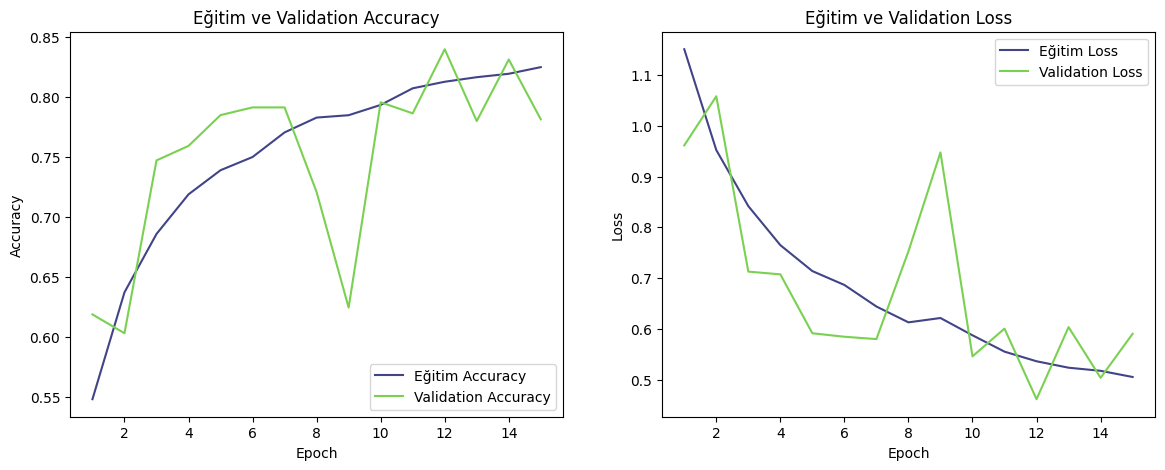

In [49]:
from matplotlib.cm import get_cmap
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stopping],
    verbose=1)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc)+1)


viridis = get_cmap("viridis")
c1, c2 = viridis(0.2), viridis(0.8)
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Eğitim Accuracy', color=c1)
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color=c2)
plt.legend(loc='lower right')
plt.title('Eğitim ve Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Eğitim Loss', color=c1)
plt.plot(epochs_range, val_loss, label='Validation Loss', color=c2)
plt.legend(loc='upper right')
plt.title('Eğitim ve Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8591 - loss: 0.4049

Test Accuracy: 0.8337
Test Loss: 0.4732
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step

Classification Report:

              precision    recall  f1-score   support

   buildings       0.84      0.85      0.84       437
      forest       0.95      0.98      0.96       474
     glacier       0.74      0.84      0.79       553
    mountain       0.82      0.69      0.75       525
         sea       0.82      0.78      0.80       510
      street       0.87      0.88      0.87       501

    accuracy                           0.83      3000
   macro avg       0.84      0.84      0.84      3000
weighted avg       0.84      0.83      0.83      3000



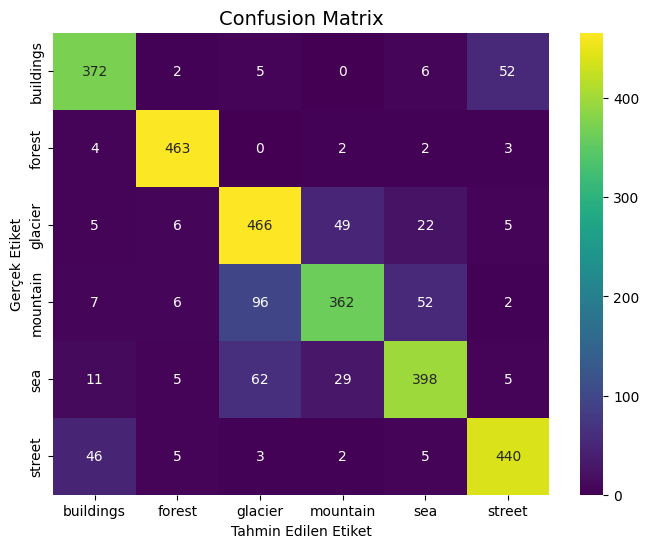

In [50]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
viridis = get_cmap("viridis")
sns.heatmap(
    cm, annot=True, fmt="d", cmap=viridis,
    xticklabels=class_names, yticklabels=class_names)

plt.title("Confusion Matrix", fontsize=14)
plt.ylabel("Gerçek Etiket")
plt.xlabel("Tahmin Edilen Etiket")
plt.show()

# Her Sınıf İçin Doğru ve Yanlış Tahmin Örnekleri
6 sınıf için doğru ve yanlış tahmin örnekleri verildi.

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


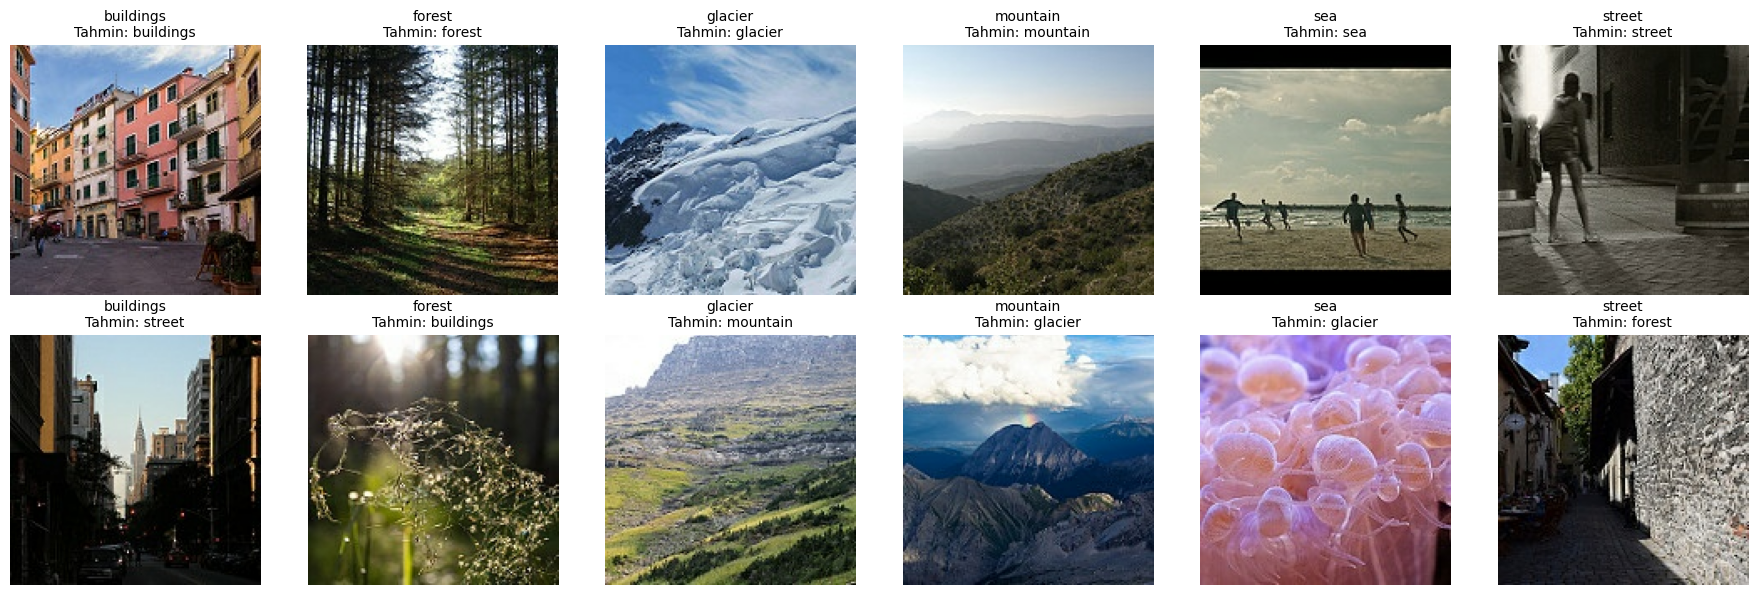

In [51]:
import random
random.seed(42)

X_test = np.concatenate([x for x, y in test_ds], axis=0)
y_true = np.concatenate([y for x, y in test_ds], axis=0)


y_pred_probs = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

plt.figure(figsize=(18, 6))


for i, cls in enumerate(class_names):
    cls_indices = np.where(y_true == i)[0]
    correct_cls = [idx for idx in cls_indices if y_pred_classes[idx] == y_true[idx]]
    if correct_cls:
        idx = random.choice(correct_cls)
        plt.subplot(2, 6, i+1)
        plt.imshow(X_test[idx].astype("uint8"))
        plt.title(f"{cls}\nTahmin: {class_names[y_pred_classes[idx]]}", fontsize=10)
        plt.axis("off")


for i, cls in enumerate(class_names):
    cls_indices = np.where(y_true == i)[0]
    incorrect_cls = [idx for idx in cls_indices if y_pred_classes[idx] != y_true[idx]]
    if incorrect_cls:
        idx = random.choice(incorrect_cls)
        plt.subplot(2, 6, 6+i+1)
        plt.imshow(X_test[idx].astype("uint8"))
        plt.title(f"{cls}\nTahmin: {class_names[y_pred_classes[idx]]}", fontsize=10)
        plt.axis("off")

plt.tight_layout()
plt.show()


# Grad-CAM 
Modelin hangi bölgelerden öğrenme yaptığını daha iyi anlayabilmek için  kullanıldı.

- **Orijinal Görsel**: Modelin gördüğü ham giriş.
- **Grad-CAM Isı Haritası**: Modelin tahmininde en çok dikkate aldığı bölgeler.
- **Overlay Görsel**: Orijinal görüntü üzerine ısı haritasının bindirilmiş hali.

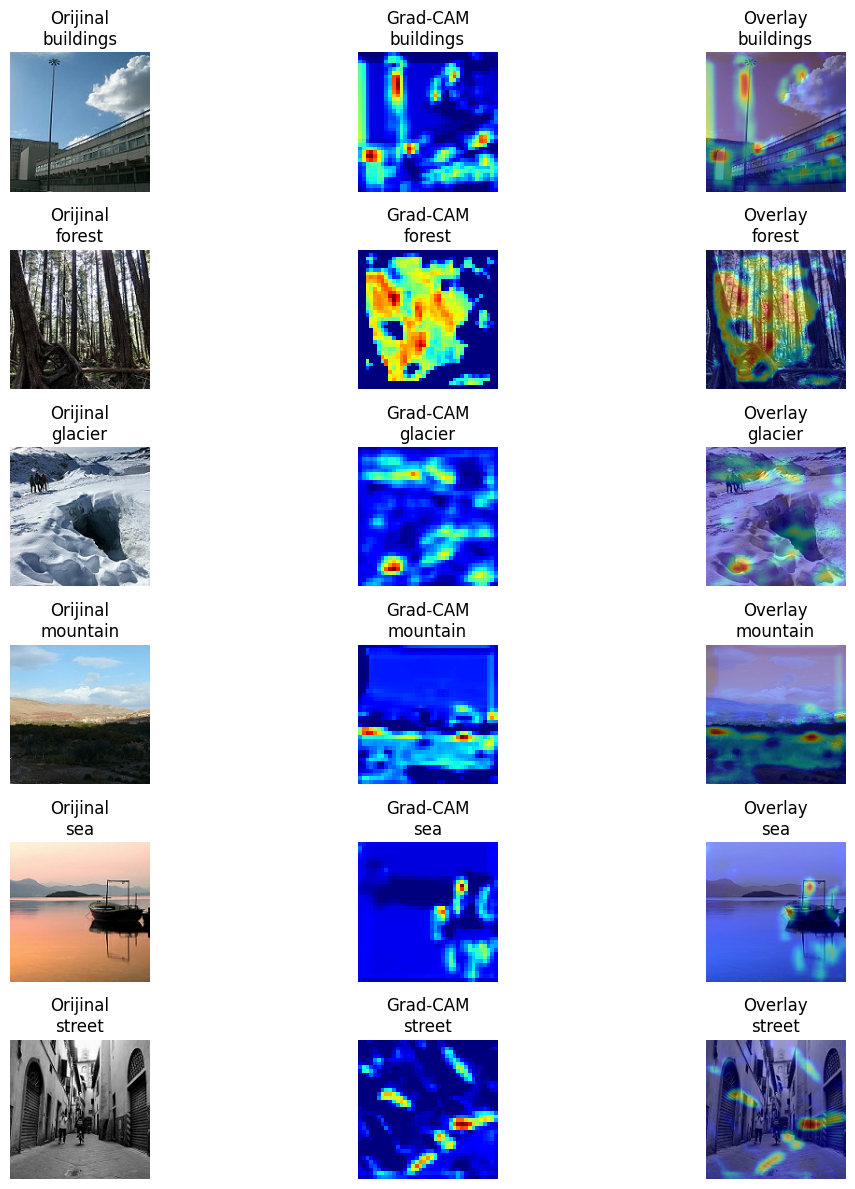

In [53]:
import random, numpy as np, cv2, matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf

random.seed(42)
np.random.seed(42)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-8)
    return heatmap.numpy() if hasattr(heatmap, "numpy") else heatmap

last_conv_layer_name = "conv2d_11"  

X_test = np.concatenate([x for x, y in test_ds], axis=0)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

plt.figure(figsize=(12, 12))
for i, cls in enumerate(class_names):
    cls_indices = np.where(y_true == i)[0]
    idx = random.choice(cls_indices)
    img = X_test[idx]
    img_array = np.expand_dims(img, axis=0)

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    img_resized = cv2.resize(img.astype("uint8"), (150, 150))
    heatmap_resized = cv2.resize(heatmap, (img_resized.shape[1], img_resized.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img_resized, 0.6, heatmap_color, 0.4, 0)

    plt.subplot(len(class_names), 3, i*3 + 1)
    plt.imshow(img_resized)
    plt.title(f"Orijinal\n{cls}")
    plt.axis("off")

    plt.subplot(len(class_names), 3, i*3 + 2)
    plt.imshow(heatmap, cmap="jet")
    plt.title(f"Grad-CAM\n{cls}")
    plt.axis("off")

    plt.subplot(len(class_names), 3, i*3 + 3)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Overlay\n{cls}")
    plt.axis("off")

plt.tight_layout()
plt.show()

 # Transfer Learning
Modelde son olarak Transfer Learning  (VGG16), 10 epoch ile eğitildi.

In [54]:
# Transfer Learning (VGG16)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import VGG16

IMG_SIZE = (224, 224)   
BATCH = 32
SEED = 42

train_ds = keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    validation_split=0.1,
    subset="training",
    seed=SEED,
    label_mode="int")

val_ds = keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    validation_split=0.1,
    subset="validation",
    seed=SEED,
    label_mode="int")

test_ds = keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False,
    label_mode="int")

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")


base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False  


model_tl = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation="softmax")])

model_tl.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

history_tl = model_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1)

Found 14034 files belonging to 6 classes.
Using 12631 files for training.
Found 14034 files belonging to 6 classes.
Using 1403 files for validation.
Found 3000 files belonging to 6 classes.
Epoch 1/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 82s 202ms/step - accuracy: 0.6384 - loss: 0.9595 - val_accuracy: 0.8403 - val_loss: 0.4295
Epoch 2/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 78s 197ms/step - accuracy: 0.8143 - loss: 0.5277 - val_accuracy: 0.8681 - val_loss: 0.3704
Epoch 3/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 77s 196ms/step - accuracy: 0.8291 - loss: 0.4690 - val_accuracy: 0.8596 - val_loss: 0.3730
Epoch 4/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 78s 196ms/step - accuracy: 0.8474 - loss: 0.4310 - val_accuracy: 0.8617 - val_loss: 0.3672
Epoch 5/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 77s 196ms/step - accuracy: 0.8476 - loss: 0.4148 - val_accuracy: 0.8867 - val_loss: 0.3316
Epoch 6/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 77s 196ms/step - accuracy: 0.8568 - loss: 0.4048 - val_accuracy: 0.8838 - val_loss: 0.3244
Epoch 7/10
395/395 ━━━━━

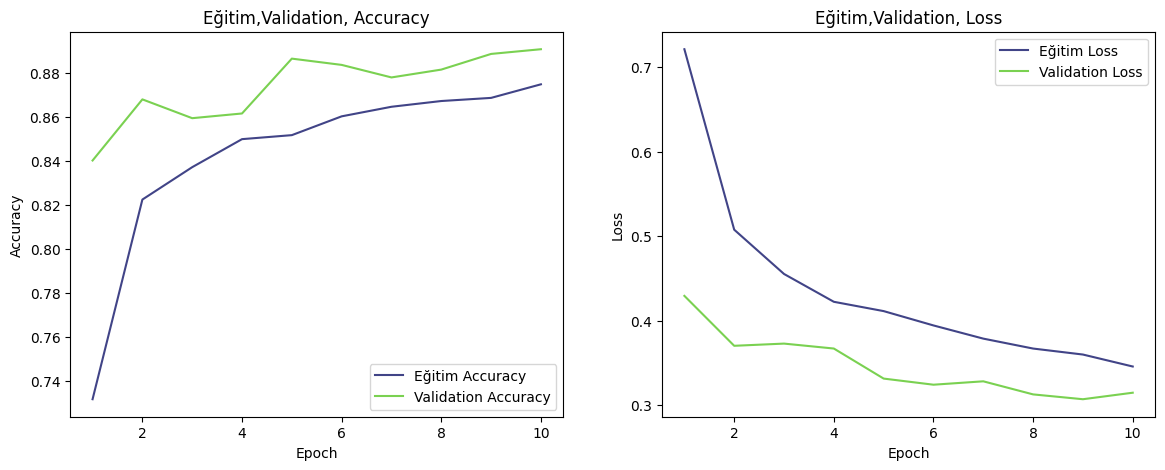

In [55]:

from matplotlib.cm import get_cmap

acc = history_tl.history['accuracy']
val_acc = history_tl.history['val_accuracy']
loss = history_tl.history['loss']
val_loss = history_tl.history['val_loss']
epochs_range = range(1, len(acc)+1)

viridis = get_cmap("viridis")
c1, c2 = viridis(0.2), viridis(0.8)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Eğitim Accuracy', color=c1)
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color=c2)
plt.legend(loc='lower right')
plt.title('Eğitim,Validation, Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Eğitim Loss', color=c1)
plt.plot(epochs_range, val_loss, label='Validation Loss', color=c2)
plt.legend(loc='upper right')
plt.title('Eğitim,Validation, Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 180ms/step - accuracy: 0.8855 - loss: 0.3097

 Transfer Learning Model - Test Accuracy: 0.8847
 Transfer Learning Model - Test Loss: 0.3275
94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 185ms/step

 Classification Report (Transfer Learning - VGG16):

              precision    recall  f1-score   support

   buildings       0.93      0.87      0.90       437
      forest       0.98      1.00      0.99       474
     glacier       0.83      0.85      0.84       553
    mountain       0.83      0.78      0.80       525
         sea       0.89      0.88      0.89       510
      street       0.88      0.95      0.91       501

    accuracy                           0.88      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.88      0.88      0.88      3000



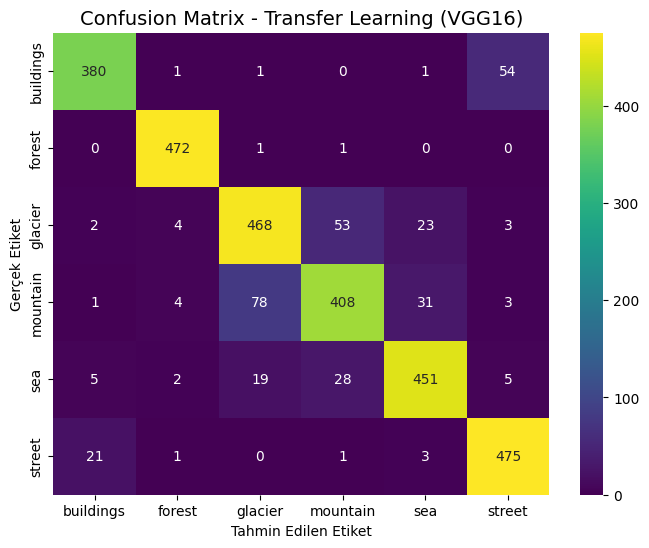

In [57]:
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from sklearn.metrics import classification_report, confusion_matrix

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

test_loss, test_acc = model_tl.evaluate(test_ds, verbose=1)
print(f"\n Transfer Learning Model - Test Accuracy: {test_acc:.4f}")
print(f" Transfer Learning Model - Test Loss: {test_loss:.4f}")


y_pred_probs = model_tl.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

print("\n Classification Report (Transfer Learning - VGG16):\n")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
viridis = get_cmap("viridis")
sns.heatmap(cm, annot=True, fmt="d", cmap=viridis,
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Transfer Learning (VGG16)", fontsize=14)
plt.ylabel("Gerçek Etiket")
plt.xlabel("Tahmin Edilen Etiket")
plt.show()


# Hiperparametre Optimizasyonu  (Learning Rate)

- Learning rate ve epoch sayısı değiştirilerek VGG16 modeli yeniden eğitildi.  
- Doğrulama temel CNN modelinden çok daha başarılı.  
- Validation loss eğrisi düzenli olarak azaldığı için modelin **overfit etmediği** gözlendi.  
- Sonuç: Küçük hiperparametre değişiklikleri  performansı anlamlı biçimde artırabiliyor.

In [59]:
from tensorflow.keras import optimizers
model_tl_lr = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation="softmax")])


model_tl_lr.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

history_tl_lr = model_tl_lr.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,  
    verbose=1)


Epoch 1/5
395/395 ━━━━━━━━━━━━━━━━━━━━ 82s 199ms/step - accuracy: 0.6545 - loss: 0.9178 - val_accuracy: 0.8389 - val_loss: 0.4302
Epoch 2/5
395/395 ━━━━━━━━━━━━━━━━━━━━ 77s 196ms/step - accuracy: 0.8087 - loss: 0.5155 - val_accuracy: 0.8653 - val_loss: 0.3677
Epoch 3/5
395/395 ━━━━━━━━━━━━━━━━━━━━ 77s 195ms/step - accuracy: 0.8356 - loss: 0.4660 - val_accuracy: 0.8788 - val_loss: 0.3534
Epoch 4/5
395/395 ━━━━━━━━━━━━━━━━━━━━ 77s 196ms/step - accuracy: 0.8443 - loss: 0.4300 - val_accuracy: 0.8639 - val_loss: 0.3618
Epoch 5/5
395/395 ━━━━━━━━━━━━━━━━━━━━ 77s 195ms/step - accuracy: 0.8506 - loss: 0.4054 - val_accuracy: 0.8774 - val_loss: 0.3337


# CNN & VGG16 Karşılaştırması

- **CNN Modeli**: Eğitim doğruluğu %84 seviyesinde kaldı.
- **VGG16 Transfer Learning**: Eğitim ve doğrulama doğruluğu %89’a kadar çıktı. 
- **Sonuç**: Transfer learning (VGG16), sıfırdan eğitilen CNN modeline kıyasla çok daha iyi genelleme yaparak daha yüksek doğruluk sağladı. 
Bu nedenle proje kapsamında transfer learning modeli tercih edildi.  

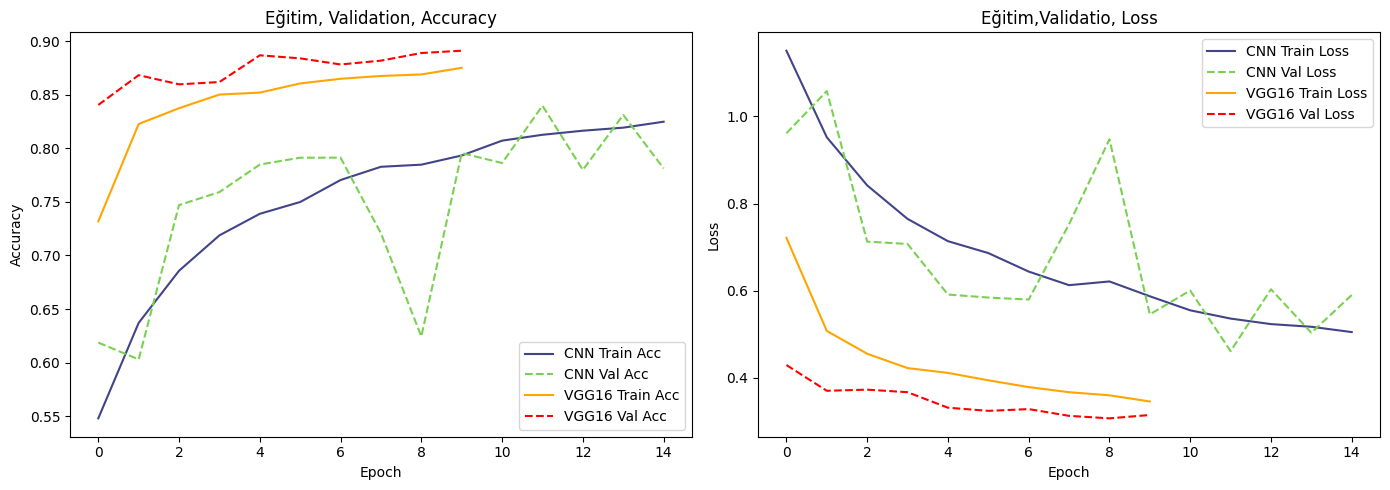

In [60]:
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt

viridis = get_cmap("viridis")
c1, c2 = viridis(0.2), viridis(0.8)

plt.figure(figsize=(14,5))


plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='CNN Train Acc', color=c1)
plt.plot(history.history['val_accuracy'], label='CNN Val Acc', color=c2, linestyle="--")
plt.plot(history_tl.history['accuracy'], label='VGG16 Train Acc', color="orange")
plt.plot(history_tl.history['val_accuracy'], label='VGG16 Val Acc', color="red", linestyle="--")
plt.title("Eğitim, Validation, Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='CNN Train Loss', color=c1)
plt.plot(history.history['val_loss'], label='CNN Val Loss', color=c2, linestyle="--")
plt.plot(history_tl.history['loss'], label='VGG16 Train Loss', color="orange")
plt.plot(history_tl.history['val_loss'], label='VGG16 Val Loss', color="red", linestyle="--")
plt.title("Eğitim,Validatio, Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


## Sonuç ve Değerlendirme

- CNN modeli temel seviyede öğrenme sağladı ancak karmaşık yapılar için yetersiz kaldı.  
- VGG16 transfer learning modeli, önceden öğrenilmiş özellikleri kullanarak daha **hızlı yakınsama** ve **daha güçlü genelleme** gösterdi.  
- Hiperparametre denemeleri, modelin performansını ince ayarlarla iyileştirebileceğimizi ortaya koydu.  
- Sonuç olarak, **görüntü sınıflandırma problemlerinde transfer learning stratejisi** hem zaman verimliliği hem de başarı açısından daha avantajlıdır.  


In [61]:
print("Mutlu kodlamalar\ngogo")

Mutlu kodlamalar
gogo
